## Setting

implémentation de [cet article](https://openreview.net/pdf?id=c8P9NQVtmnO)

Avec quelques modifications

In [ ]:
%reload_ext autoreload
%autoreload 2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%reset -f
#%cd /content/drive/MyDrive/ML_Burgers/
%cd /content/drive/MyDrive/RECHERCHE3

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/17bT9qzfPBT-758cXfyfE3KbFtOk0U2aT/RECHERCHE3


In [ ]:
%ls

ddqn_lib/                        GCN/       PINO_article/       transformer/
Euler/                           Hamilton/  popup_lib/          translations/
fourier_neural_operator/         Pinns/     poubel/
fourier_neural_operator_master/  Pinns.zip  ReducedBasisPInns/


In [ ]:
pp=print
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
from fourier_neural_operator.fourier_1d_plus import *

## Définition du problème

On demande au modèle de faire le lien entre les deux fonctions suivantes:

Input:

        lambda x, nu: -tf.sin(nu * x)+0.5*tf.sin(2*nu * x)

Output:

        lambda x, nu: tf.cos(nu * x) ** 5 +0.3*tf.cos(2*nu * x)


pour différents `nu`



## Définition du modèle

In [ ]:
data_creator_train=DataCreator1D(nx=80,batch_size=64)

model = FNO1d_plus(modes=16, width=10,out_channels=1,first_channel_unchanged=False,pad_prop=0.05,freq_mix_size=0)
optimizer=tf.keras.optimizers.Adam()

modèle FNO1d crée avec comme hyperparamètre: modes:16, width:10,level:4, pad_prop:0.05 


Voici la signature du modèle

        FNO1d_plus( modes:int, width:int,out_channels,first_channel_unchanged,pad_prop,freq_mix_size):

* modes: nombre de coefficients de fourier gardés
* width: dimension de travail des layers
* out_channels: dimension de sorite
* first_channel_unchanged=True Si l'on veut garder les fréquences inchangée dans le premier channel, à l'initialisation des poids (sorte de res-net fréquentiel)
* pad_prop: le padding est pad_prop*len(signal)
* freq_mix_size=4: des convolutions de tailles 4 sont appliquées au fréquences (pour l'instant, cela n'a améliorer les choses)


Voici la signature d'un layer. Remarquons qu'un layer peut servir de prétraitement à un autre réseau (ex: Unet). Car il permet d'interpoler (possibilité d'imposer un longueur de signal en sortie avec l'argument `N_out_imposed`). 

        SpectralConv1d_plus(self, in_channels:int, out_channels:int, modes:int,first_channel_unchanged:bool,N_out_imposed=None,freq_mix_size=0):


* in_channels:int dimension d'entrée
* out_channels:int dimension de sortie
* modes:int nombre de fréquences filtrées
* first_channel_unchanged:bool: voir au dessus
* N_out_imposed: si l'on veut que la longueur du signal en sortie soit différente de celle en entrée.
* freq_mix_size=0: voir au dessus


Poids du layer avant entrainement

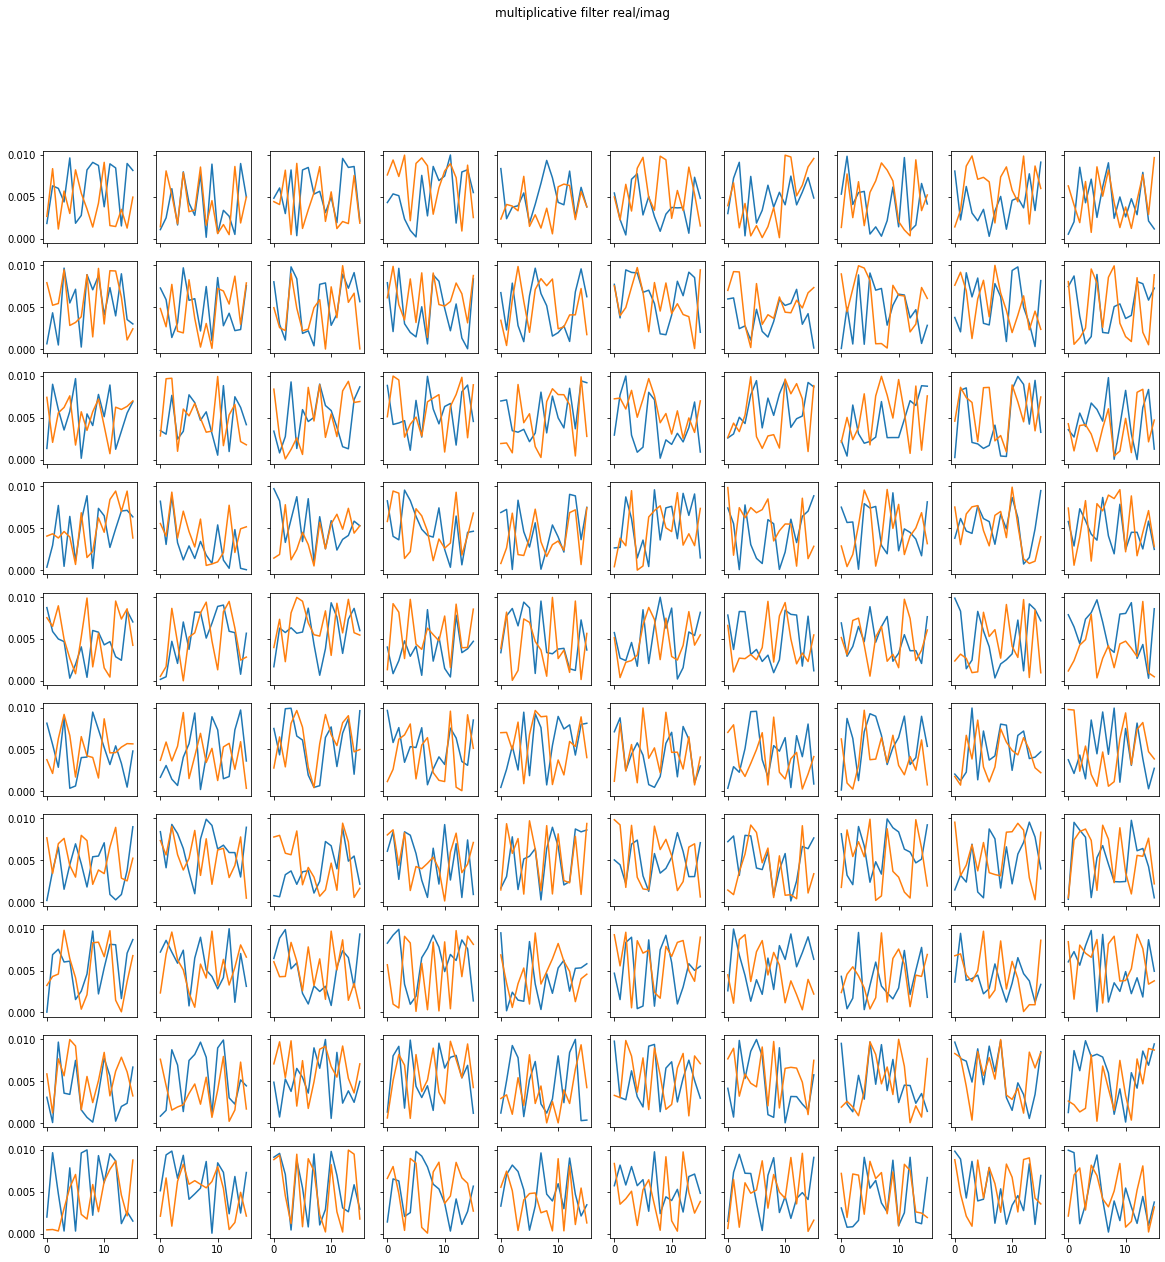

In [ ]:
#premier layer du modèle
model.convs[0].inspect_weiths()

In [ ]:
losses=[]

In [ ]:
try:
    for i in range(1000):
        A,U=data_creator_train.call()

        with tf.GradientTape() as tape:
            U_hat=model.call(A)
            loss=data_creator_train.loss(U,U_hat)

        grad=tape.gradient(loss,model.trainable_variables)
        optimizer.apply_gradients(zip(grad,model.trainable_variables))
        losses.append(loss.numpy())

        if i%10==0:
            print(f"MSE train error at step:{i}: {loss.numpy()}",)
except KeyboardInterrupt:
    pass

traçage de la fonction call_acc
traçage de la fonction call_acc
MSE train error at step:0: 0.42908352613449097
MSE train error at step:10: 0.42887139320373535
MSE train error at step:20: 0.38284820318222046
MSE train error at step:30: 0.3597564101219177
MSE train error at step:40: 0.44015222787857056
MSE train error at step:50: 0.3828499913215637
MSE train error at step:60: 0.2557923495769501
MSE train error at step:70: 0.21105130016803741
MSE train error at step:80: 0.15002809464931488
MSE train error at step:90: 0.13935799896717072
MSE train error at step:100: 0.07091717422008514
MSE train error at step:110: 0.07150964438915253
MSE train error at step:120: 0.06906571239233017
MSE train error at step:130: 0.055796556174755096
MSE train error at step:140: 0.04863131791353226
MSE train error at step:150: 0.047290652990341187
MSE train error at step:160: 0.033765584230422974
MSE train error at step:170: 0.030342459678649902
MSE train error at step:180: 0.023846816271543503
MSE train erro

## Test dans la résolution de l'entrainement

MSE error with resolution nx:80: tf.Tensor(0.002153783, shape=(), dtype=float32)


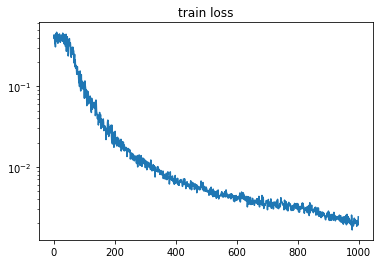

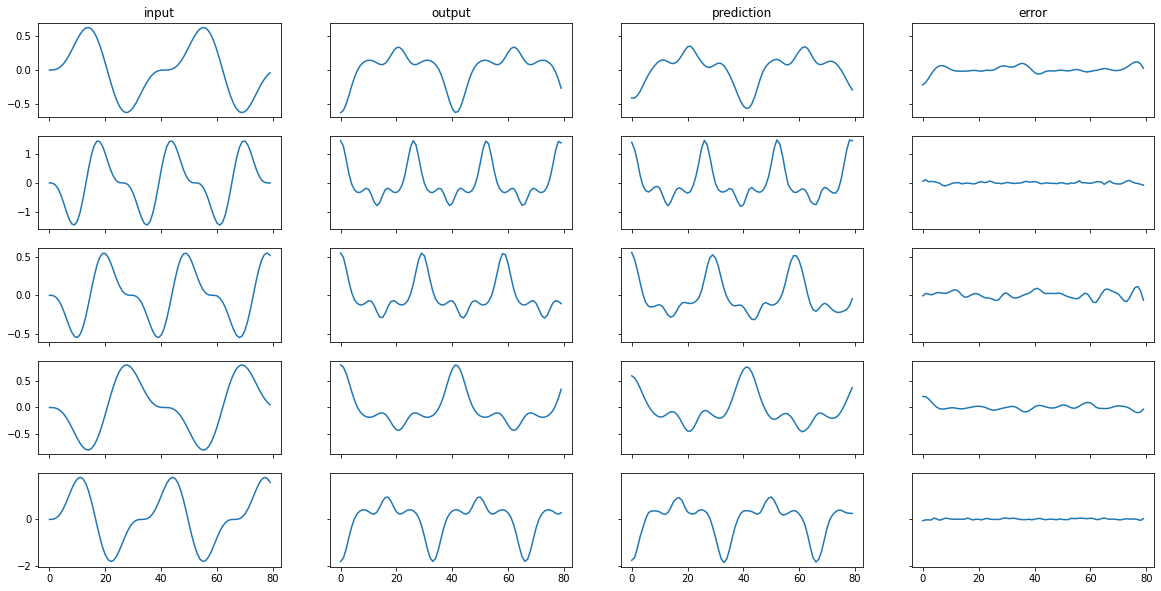

In [ ]:
fig,ax=plt.subplots()
ax.plot(losses)
ax.set_title("train loss")
ax.set_yscale("log")

display_results(data_creator_train,model)

## Test avec résolution supèrieure

traçage de la fonction call_acc
MSE error with resolution nx:150: tf.Tensor(0.0030643847, shape=(), dtype=float32)


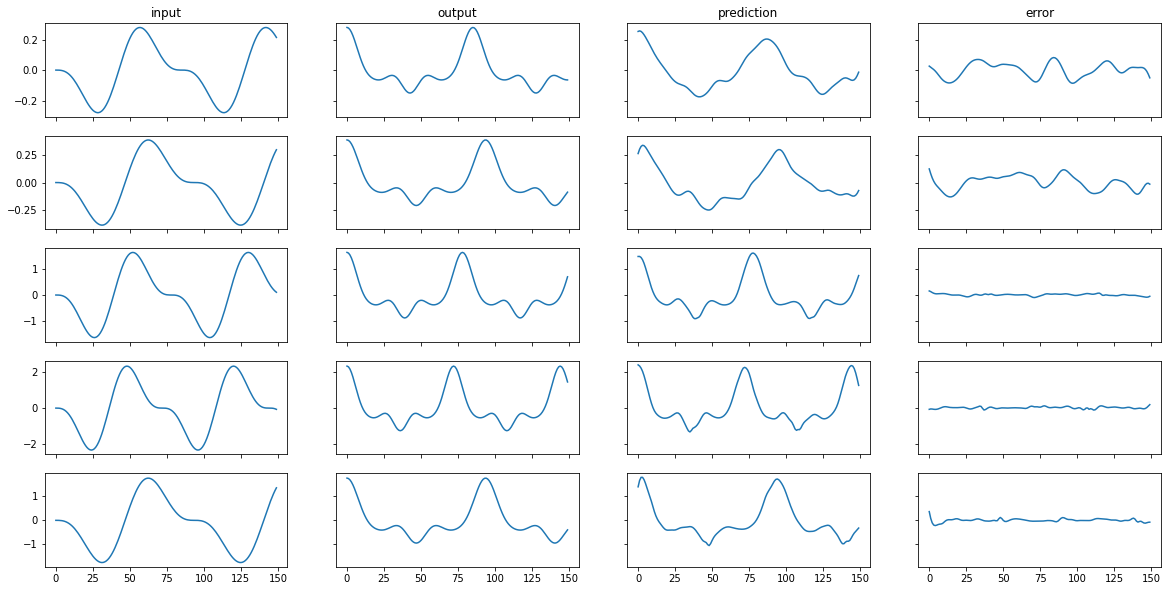

In [ ]:
data_creator_test=DataCreator1D(150,64)
display_results(data_creator_test,model)

## Test avec résolution inférieure

traçage de la fonction call_acc
MSE error with resolution nx:50: tf.Tensor(0.0040565426, shape=(), dtype=float32)


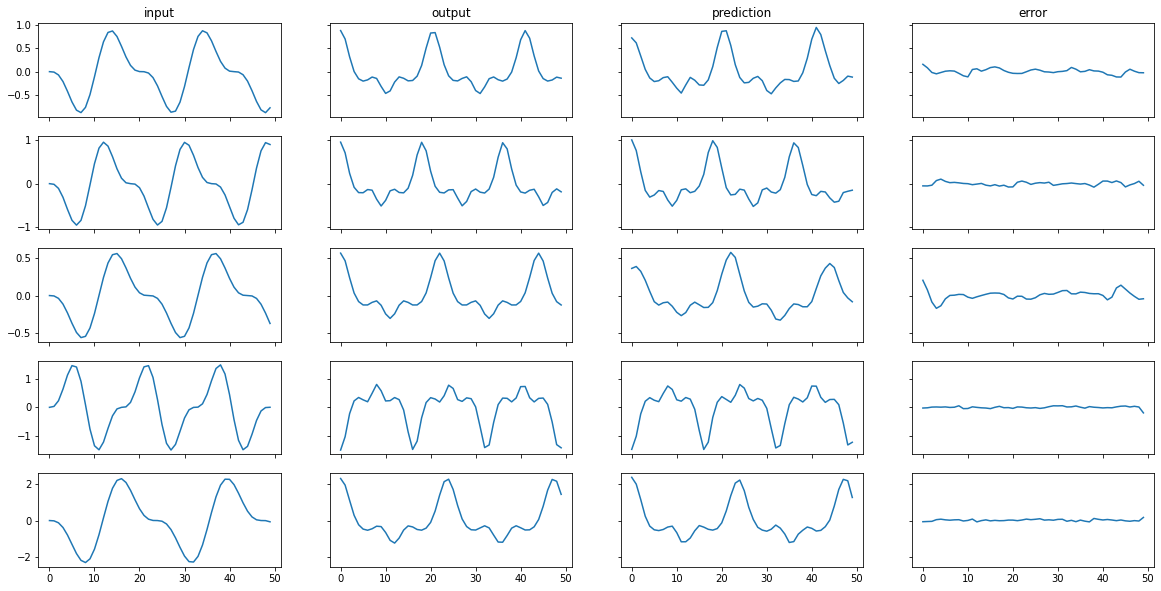

In [ ]:
data_creator_test=DataCreator1D(50,64)
display_results(data_creator_test,model)

## Poids des layers FNO après entrainements

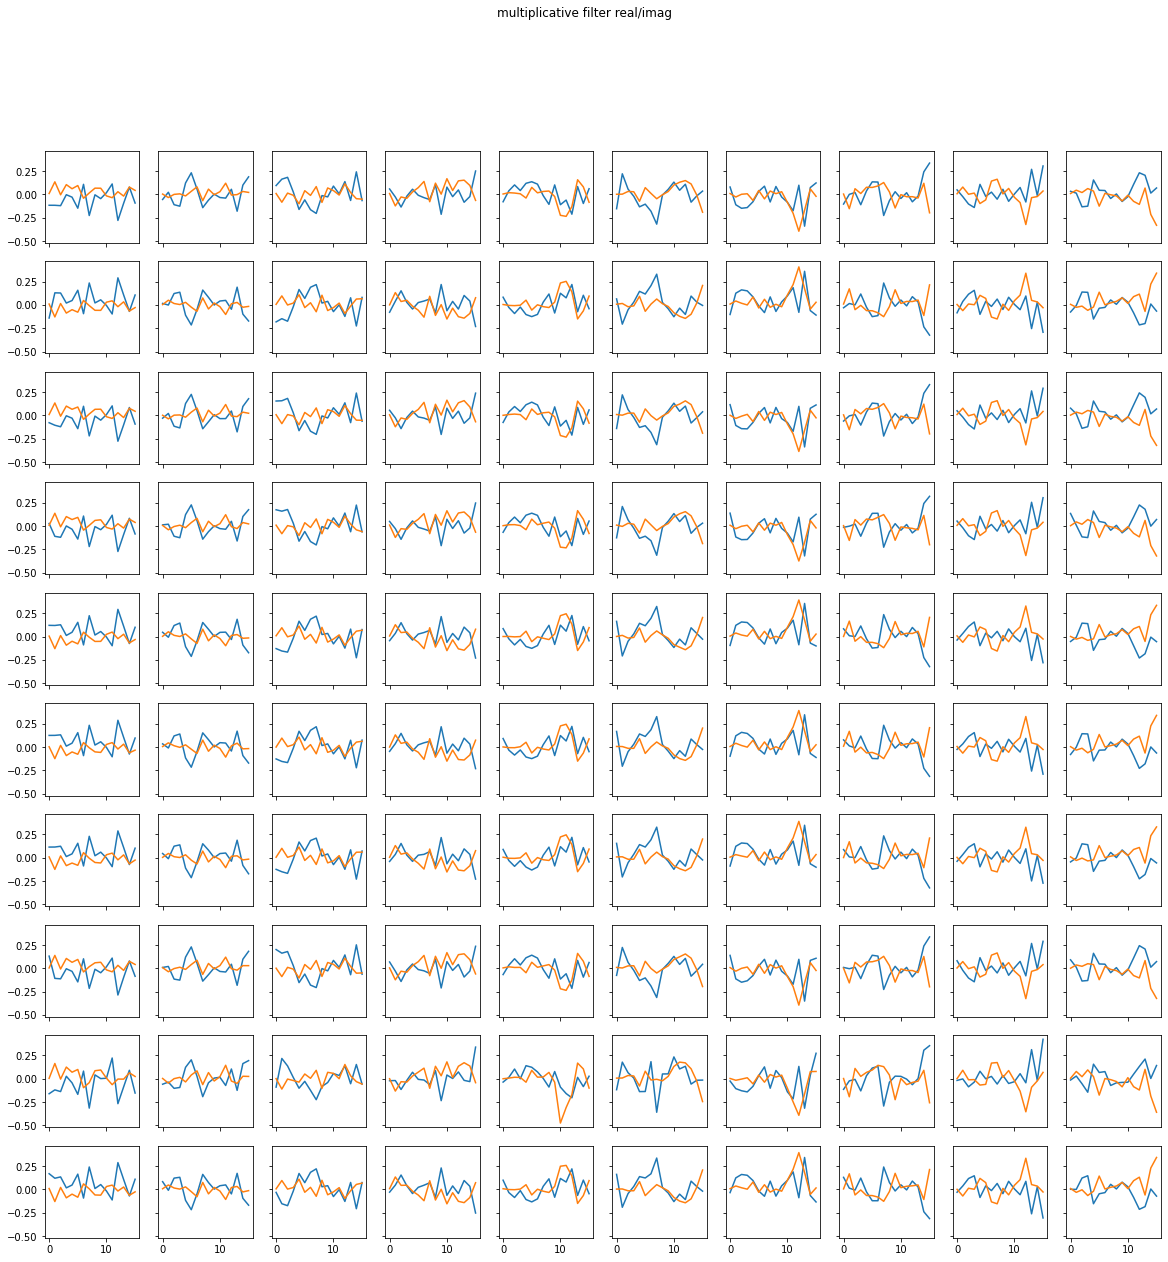

In [ ]:
#premier layer
model.convs[0].inspect_weiths()

In [ ]:
#second layer
#model.convs[1].inspect_weiths()

In [ ]:
#troisème layer
#model.convs[2].inspect_weiths()

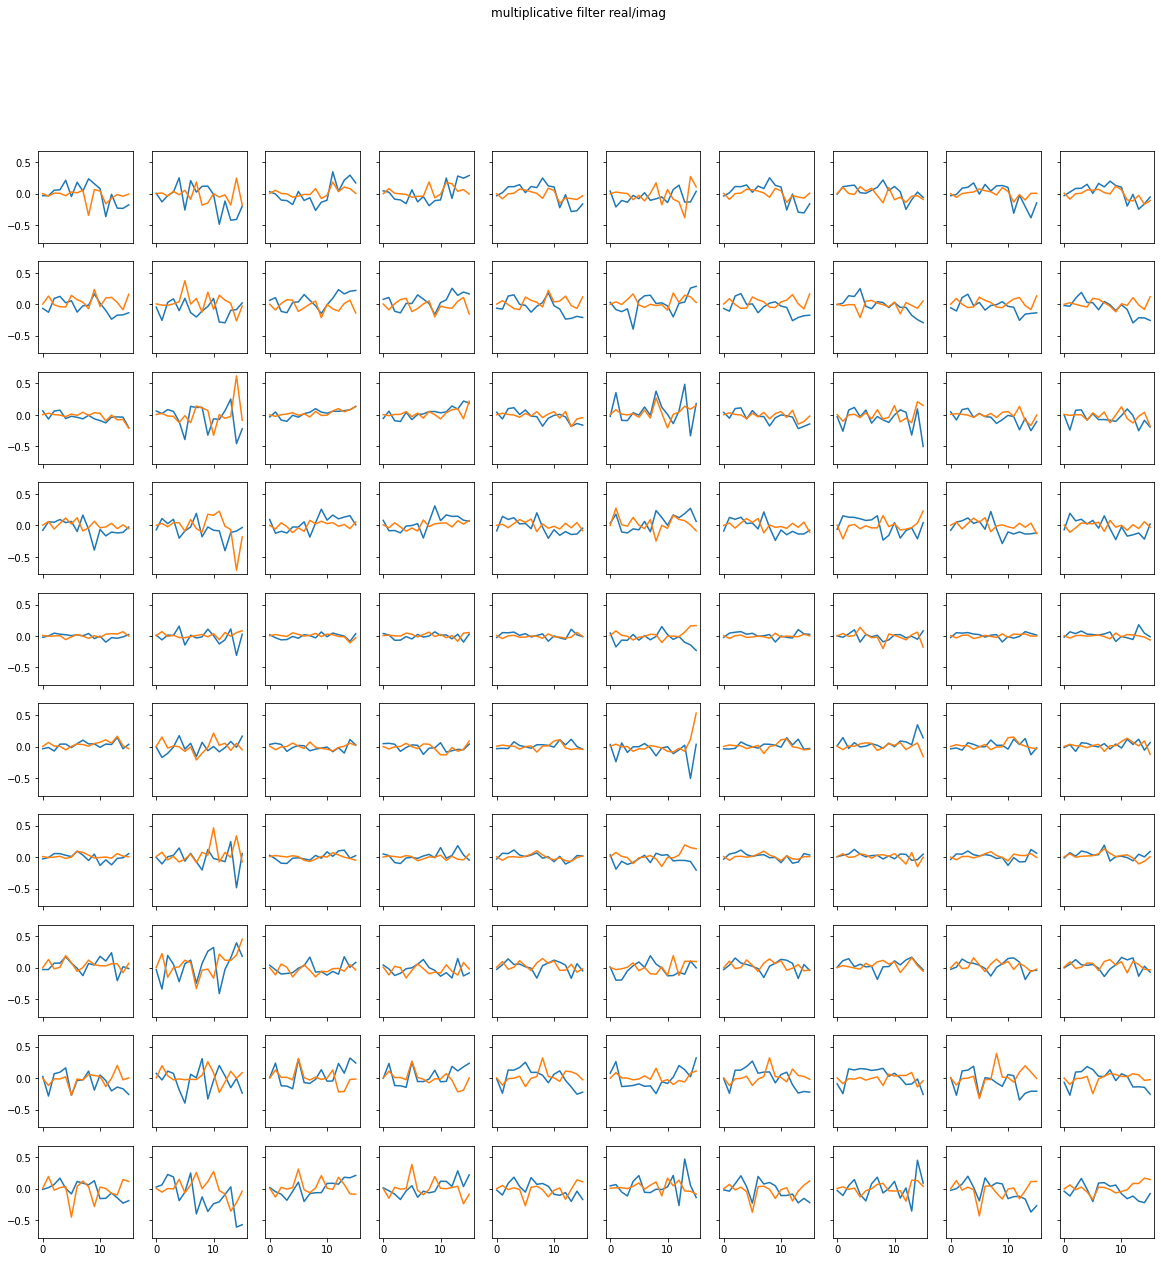

In [ ]:
#quatrième layer
model.convs[3].inspect_weiths()